### GCN and GNN-Differential-Pooling implementation for Fake News Detection on UPFD dataset

# Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

import torch_geometric
torch_geometric.__version__

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622717 sha256=362d630be8d582ba8a0b8dfe4efd0c5518f6ef26a68c9f225afd53cabfb1215e
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=2846209 sha256=065babeae7d02167108fdd830590f976fafaf5513ca9fd084df6c81662096cbd
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Su

'2.6.1'

In [3]:
import argparse
import os.path as osp
import numpy as np
from math import ceil
import pandas as pd
import copy
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool, DenseSAGEConv
from torch_geometric.transforms import ToUndirected
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torch_geometric.nn import global_mean_pool as gmp

import torch.nn.functional as F
from torch_geometric.data import DenseDataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch.utils.data import random_split

# GCN
## Load Data

In [4]:
def load_data(split):
  """
  Load train, validation, and test data from the UPFD dataset in PyG. Concact node
  features *profile* and *bert*, which are Twitter user's profile attributes and
  historical tweets encoded through BERT respectively.

  -------------------------------------
  split: 'train', 'val', or 'test' for retrieving the respective portion of UPFD.

  -------------------------------------
  Return: PyG dataset object.
  """

  data_profile =  UPFD('/tmp/test', "politifact", "profile", split, ToUndirected())
  data_bert =  UPFD('/tmp/test', "politifact", "bert", split, ToUndirected())
  data_profile.data.x = torch.cat((data_profile.data.x, data_bert.data.x),dim =1)

  return data_profile

In [5]:
# Retrieve data
train_data = load_data('train')
test_data = load_data('test')
val_data = load_data('val')

# Prepare data loader for GNN
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Extracting /tmp/test/politifact/raw/data.zip
Processing...
Done!
Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## GCN Architecture

In [6]:
class GCN(torch.nn.Module):
  def __init__(self, args):
    """
    Initialize a simple GCN with specific parameters.

    By default, this GCN has 2 convolutional layers and 1 linear layer.
    It also has 1 layer of batch normalization between the two conv-layers.

    If num_layers is provided by user, then this function initializes
    corresponding number of convolutional layers, with batch normalization
    in between. Num_layers must be >= 2.

    -------------------------------------
    self: GCN object
    args["num_features"]: dimension of the input
    args["hidden_dim"]: dimension of the hidden layer(s)
    args["num_classes"]: dimension of the output (i.e. number of classes)
    args["dropout"]: percentage of neurons being zeroed, can be None
    args["num_layers"]: number of convolutional layers, must be >= 2

    """

    assert args.num_layers >= 2, "num_layers must be >= 2."

    super(GCN, self).__init__()

    # Initialize parameters
    self.num_layers = args.num_layers
    self.dropout = args.dropout

    # Initialize the first convolutional layer
    self.convs = torch.nn.ModuleList([GCNConv(args.num_features, args.hidden_dim)])

    # Initialize batch normalization layer
    self.bns = torch.nn.ModuleList()

    # Initialize batch normalization layer(s) and the rest of the convolutional layer(s)
    for _ in range(self.num_layers - 1):

      # Initialize the batch normalization layer
      self.bns.extend([torch.nn.BatchNorm1d(args.hidden_dim)])

      # Initialize the second convolutional layer
      self.convs.extend([GCNConv(args.hidden_dim, args.hidden_dim)])

    # Initialize the final linear layer
    self.lin0 = Linear(args.hidden_dim, args.num_classes)



  def reset_parameters(self):
    """
    Reset training parameters for gradient descent.
    """
    for conv in self.convs:
        conv.reset_parameters()
    for bn in self.bns:
        bn.reset_parameters()

  def forward(self, data):
    """
    One forward pass with GCN.

    -------------------------------------
    data: PyG Dataset data object, with properties like x, edge_index, batch, etc.

    -------------------------------------
    Return: prediction at the end of one epoch.
    """

    # get features and adjacency matrix
    # -- the batch propery associate nodes within one graph together, it takes
    #    the form of [1,...,1,2,...2,...,n,...,n] with n being the number of
    #    independent graphs in the entire dataset
    out, edge_index, batch = data.x, data.edge_index, data.batch

    # apply one layer of GNN at a time
    for i in range(self.num_layers - 1):

      # convolutional layer
      out = self.convs[i](out, edge_index)

      # batch normalization
      out = self.bns[i](out)

      # non-linear activation with Re-Lu
      out = F.relu(out)

      # drop out if requested
      if self.dropout > 0:
        out = F.dropout(out, training=self.training)

    # the last convolutional layer
    out = self.convs[i+1](out, edge_index)

    # apply graph level pooling per batch (each bath is one indenpendent graph)
    # -- embeddings of each batch/graph with k nodes (1 news node, k-1 user nodes)
    #    are pooled with the mean method to generate a batch/graph level embedding
    #    for lebel prediction
    out = gmp(out, batch)

    df = pd.DataFrame(data=out.detach().numpy())
    df.to_csv('embed.csv', sep=' ', header=False, index=False)

    # the final linear layer
    out = self.lin0(out)

    # soft max for final prediction
    out = F.log_softmax(out, dim=-1)

    return out


In [7]:
def forward_for_viz(data):
  """
  Function to output the visualization in Medium post
  """

  out, edge_index, batch = data.x, data.edge_index, data.batch

  out = gmp(out, batch)

  return out

## GCN Model Training

In [8]:
"""
parser add argument (optimizer, loss_fn, eval_metrics defualt accuracy)
"""

def train(model, data, optimizer, loss_fn):
  """
  Train the model using given data, optimizer, and loss_fn
  --------------------------------------
  model: the model we specified
  data: train data multiple batches of graphs, therefore needs to loop through each batch of graph
        and add loss of each graph results.
  """
  out_loss = 0.0
  for i, data in enumerate(data):

    optimizer.zero_grad()
    data = data.to(args.device)
    out = model(data)
    y = data.y
    loss = loss_fn(out,y)

    loss.backward()
    optimizer.step()

    out_loss += loss.item()

  return out_loss


## GCN Model Performance

In [9]:
@torch.no_grad()
def evaluate(model, loader, eval_metric = 'all'):
  """
  Evaluate performance of the a GCN model based on the eval_metric.
  """

  # Put model in evaluation mode
  model.eval()

  pred = []
  label = []

  for data in loader:
    pred_y = model(data).argmax(dim=-1, keepdim=True).tolist()
    pred.extend(pred_y)
    label.extend(data.y)

  acc = accuracy_score(label, pred)
  f1 = f1_score(label, pred)
  auc = roc_auc_score(label, pred)

  return acc, f1, auc


## Run GCN Model

In [10]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--hidden_dim', type=int, default=128, help='hidden size')
parser.add_argument('--dropout', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=100, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='sage', help='model type, [gcn, gat, sage]')
parser.add_argument('--eval', type = str, default = 'accuracy', help = 'evaluation type')
parser.add_argument('--num_layers', type=str, default = 2, help = 'num of GNN layers')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

args.num_classes = train_data.num_classes
args.num_features = train_data.num_features

model = GCN(args)
model = model.to(args.device)

In [11]:
#if __name__ == '__main__':
model.reset_parameters()

best_model = None
best_val_value = 0

evaluator = args.eval

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.weight_decay)
loss_fn = F.nll_loss

model.train()
for epoch in tqdm(range(1, args.epochs)):
  loss = train(model, train_loader, optimizer, loss_fn)
  train_eval = evaluate(model, train_loader)
  val_eval = evaluate(model, val_loader)
  if val_eval[0] > best_val_value:
    best_val_value = val_eval[0]
    best_model = copy.deepcopy(model)
  print(f'loss_train:{loss:.4f}, train_{evaluator}:{train_eval[0]:.4f}, val_{evaluator}:{val_eval[0]:.4f} ')
acc, f1, auc = evaluate(best_model, test_loader)
print(f'Test results: acc {acc:.4f}, f1 score: {f1:.4f}, auc: {auc:.4f}' )

  1%|          | 1/99 [00:01<01:52,  1.15s/it]

loss_train:0.7377, train_accuracy:0.5806, val_accuracy:0.4194 


  2%|▏         | 2/99 [00:02<01:37,  1.01s/it]

loss_train:2.7296, train_accuracy:0.7419, val_accuracy:0.7742 


  3%|▎         | 3/99 [00:02<01:27,  1.09it/s]

loss_train:0.6723, train_accuracy:0.4194, val_accuracy:0.5806 


  4%|▍         | 4/99 [00:03<01:20,  1.18it/s]

loss_train:0.7575, train_accuracy:0.5806, val_accuracy:0.4194 


  5%|▌         | 5/99 [00:03<01:00,  1.54it/s]

loss_train:0.6781, train_accuracy:0.5806, val_accuracy:0.4194 


  6%|▌         | 6/99 [00:04<00:52,  1.78it/s]

loss_train:0.7401, train_accuracy:0.5806, val_accuracy:0.4194 


  7%|▋         | 7/99 [00:04<00:44,  2.05it/s]

loss_train:0.6845, train_accuracy:0.5806, val_accuracy:0.4194 


  8%|▊         | 8/99 [00:05<00:44,  2.06it/s]

loss_train:0.6814, train_accuracy:0.5484, val_accuracy:0.6452 


  9%|▉         | 9/99 [00:05<00:47,  1.90it/s]

loss_train:0.6899, train_accuracy:0.5806, val_accuracy:0.4194 


 10%|█         | 10/99 [00:06<00:40,  2.19it/s]

loss_train:0.6776, train_accuracy:0.5806, val_accuracy:0.4194 


 11%|█         | 11/99 [00:06<00:34,  2.58it/s]

loss_train:0.6716, train_accuracy:0.5806, val_accuracy:0.4194 


 12%|█▏        | 12/99 [00:06<00:29,  2.93it/s]

loss_train:0.6744, train_accuracy:0.5806, val_accuracy:0.4194 


 14%|█▍        | 14/99 [00:06<00:22,  3.73it/s]

loss_train:0.6658, train_accuracy:0.5806, val_accuracy:0.4194 
loss_train:0.6650, train_accuracy:0.5806, val_accuracy:0.4194 


 15%|█▌        | 15/99 [00:07<00:20,  4.00it/s]

loss_train:0.6623, train_accuracy:0.5806, val_accuracy:0.4194 


 16%|█▌        | 16/99 [00:07<00:19,  4.19it/s]

loss_train:0.6554, train_accuracy:0.5806, val_accuracy:0.4194 


 17%|█▋        | 17/99 [00:07<00:19,  4.30it/s]

loss_train:0.6511, train_accuracy:0.5806, val_accuracy:0.4194 


 19%|█▉        | 19/99 [00:07<00:17,  4.57it/s]

loss_train:0.6443, train_accuracy:0.5806, val_accuracy:0.4194 
loss_train:0.6347, train_accuracy:0.6774, val_accuracy:0.4516 


 20%|██        | 20/99 [00:08<00:17,  4.55it/s]

loss_train:0.6301, train_accuracy:0.5806, val_accuracy:0.4194 


 21%|██        | 21/99 [00:08<00:17,  4.51it/s]

loss_train:0.6140, train_accuracy:0.5806, val_accuracy:0.4194 


 23%|██▎       | 23/99 [00:08<00:16,  4.71it/s]

loss_train:0.6056, train_accuracy:0.8387, val_accuracy:0.6774 
loss_train:0.5854, train_accuracy:0.8065, val_accuracy:0.7742 


 24%|██▍       | 24/99 [00:09<00:15,  4.71it/s]

loss_train:0.5740, train_accuracy:0.5806, val_accuracy:0.4194 


 25%|██▌       | 25/99 [00:09<00:15,  4.71it/s]

loss_train:0.5665, train_accuracy:0.8226, val_accuracy:0.8065 


 27%|██▋       | 27/99 [00:09<00:14,  4.85it/s]

loss_train:0.5421, train_accuracy:0.8710, val_accuracy:0.7097 
loss_train:0.5106, train_accuracy:0.8871, val_accuracy:0.6774 


 29%|██▉       | 29/99 [00:10<00:13,  5.01it/s]

loss_train:0.4901, train_accuracy:0.7903, val_accuracy:0.8065 
loss_train:0.4899, train_accuracy:0.6290, val_accuracy:0.4516 


 30%|███       | 30/99 [00:10<00:13,  5.03it/s]

loss_train:0.5276, train_accuracy:0.8065, val_accuracy:0.8065 


 31%|███▏      | 31/99 [00:10<00:13,  4.94it/s]

loss_train:0.4596, train_accuracy:0.8387, val_accuracy:0.8065 


 33%|███▎      | 33/99 [00:10<00:13,  4.98it/s]

loss_train:0.3976, train_accuracy:0.8226, val_accuracy:0.6129 
loss_train:0.4295, train_accuracy:0.7581, val_accuracy:0.7419 


 35%|███▌      | 35/99 [00:11<00:12,  4.98it/s]

loss_train:0.4737, train_accuracy:0.8710, val_accuracy:0.7097 
loss_train:0.3876, train_accuracy:0.8871, val_accuracy:0.8387 


 36%|███▋      | 36/99 [00:11<00:12,  5.05it/s]

loss_train:0.3385, train_accuracy:0.8226, val_accuracy:0.7742 


 38%|███▊      | 38/99 [00:11<00:12,  5.03it/s]

loss_train:0.3897, train_accuracy:0.8387, val_accuracy:0.6774 
loss_train:0.3726, train_accuracy:0.8871, val_accuracy:0.8065 


 39%|███▉      | 39/99 [00:12<00:11,  5.06it/s]

loss_train:0.2963, train_accuracy:0.8871, val_accuracy:0.8065 


 41%|████▏     | 41/99 [00:12<00:11,  5.02it/s]

loss_train:0.3173, train_accuracy:0.8226, val_accuracy:0.6452 
loss_train:0.3627, train_accuracy:0.8710, val_accuracy:0.8065 


 43%|████▎     | 43/99 [00:12<00:11,  5.08it/s]

loss_train:0.3040, train_accuracy:0.9355, val_accuracy:0.8065 
loss_train:0.2489, train_accuracy:0.9032, val_accuracy:0.6774 


 44%|████▍     | 44/99 [00:13<00:10,  5.09it/s]

loss_train:0.2814, train_accuracy:0.8548, val_accuracy:0.8065 


 46%|████▋     | 46/99 [00:13<00:10,  4.98it/s]

loss_train:0.3190, train_accuracy:0.8871, val_accuracy:0.6774 
loss_train:0.2857, train_accuracy:0.9516, val_accuracy:0.8065 


 47%|████▋     | 47/99 [00:13<00:10,  4.83it/s]

loss_train:0.2175, train_accuracy:0.8871, val_accuracy:0.8065 


 48%|████▊     | 48/99 [00:13<00:11,  4.33it/s]

loss_train:0.2255, train_accuracy:0.8871, val_accuracy:0.6774 


 49%|████▉     | 49/99 [00:14<00:12,  4.00it/s]

loss_train:0.2798, train_accuracy:0.8710, val_accuracy:0.8065 


 51%|█████     | 50/99 [00:14<00:12,  3.93it/s]

loss_train:0.2753, train_accuracy:0.9032, val_accuracy:0.7419 


 52%|█████▏    | 51/99 [00:14<00:12,  3.85it/s]

loss_train:0.2152, train_accuracy:0.9677, val_accuracy:0.8387 


 53%|█████▎    | 52/99 [00:15<00:12,  3.64it/s]

loss_train:0.1789, train_accuracy:0.8710, val_accuracy:0.8387 


 54%|█████▎    | 53/99 [00:15<00:12,  3.60it/s]

loss_train:0.2123, train_accuracy:0.9032, val_accuracy:0.6774 


 55%|█████▍    | 54/99 [00:15<00:12,  3.52it/s]

loss_train:0.2549, train_accuracy:0.8871, val_accuracy:0.8387 


 56%|█████▌    | 55/99 [00:15<00:12,  3.44it/s]

loss_train:0.2242, train_accuracy:0.9677, val_accuracy:0.8387 


 57%|█████▋    | 56/99 [00:16<00:12,  3.52it/s]

loss_train:0.1684, train_accuracy:0.9677, val_accuracy:0.8387 


 58%|█████▊    | 57/99 [00:16<00:11,  3.51it/s]

loss_train:0.1589, train_accuracy:0.8871, val_accuracy:0.8387 


 59%|█████▊    | 58/99 [00:16<00:11,  3.42it/s]

loss_train:0.1950, train_accuracy:0.9032, val_accuracy:0.6774 


 61%|██████    | 60/99 [00:17<00:10,  3.88it/s]

loss_train:0.2221, train_accuracy:0.8871, val_accuracy:0.8387 
loss_train:0.1897, train_accuracy:0.9839, val_accuracy:0.8387 


 62%|██████▏   | 61/99 [00:17<00:09,  4.07it/s]

loss_train:0.1449, train_accuracy:0.9839, val_accuracy:0.8710 


 63%|██████▎   | 62/99 [00:17<00:08,  4.30it/s]

loss_train:0.1388, train_accuracy:0.9032, val_accuracy:0.8387 


 64%|██████▎   | 63/99 [00:17<00:08,  4.30it/s]

loss_train:0.1672, train_accuracy:0.9032, val_accuracy:0.7097 


 65%|██████▍   | 64/99 [00:18<00:07,  4.42it/s]

loss_train:0.1905, train_accuracy:0.9032, val_accuracy:0.8387 


 67%|██████▋   | 66/99 [00:18<00:07,  4.67it/s]

loss_train:0.1729, train_accuracy:0.9839, val_accuracy:0.8065 
loss_train:0.1390, train_accuracy:0.9839, val_accuracy:0.8710 


 68%|██████▊   | 67/99 [00:18<00:06,  4.70it/s]

loss_train:0.1195, train_accuracy:0.9516, val_accuracy:0.8710 


 69%|██████▊   | 68/99 [00:18<00:06,  4.69it/s]

loss_train:0.1325, train_accuracy:0.9516, val_accuracy:0.7419 


 71%|███████   | 70/99 [00:19<00:06,  4.79it/s]

loss_train:0.1567, train_accuracy:0.9194, val_accuracy:0.8387 
loss_train:0.1628, train_accuracy:0.9516, val_accuracy:0.7419 


 73%|███████▎  | 72/99 [00:19<00:05,  4.93it/s]

loss_train:0.1539, train_accuracy:0.9516, val_accuracy:0.8710 
loss_train:0.1257, train_accuracy:0.9839, val_accuracy:0.8710 


 75%|███████▍  | 74/99 [00:20<00:05,  4.90it/s]

loss_train:0.1074, train_accuracy:0.9839, val_accuracy:0.8710 
loss_train:0.1105, train_accuracy:0.9516, val_accuracy:0.8710 


 77%|███████▋  | 76/99 [00:20<00:04,  5.03it/s]

loss_train:0.1253, train_accuracy:0.9516, val_accuracy:0.7419 
loss_train:0.1412, train_accuracy:0.9194, val_accuracy:0.8387 


 78%|███████▊  | 77/99 [00:20<00:04,  4.94it/s]

loss_train:0.1445, train_accuracy:0.9516, val_accuracy:0.7419 


 79%|███████▉  | 78/99 [00:21<00:04,  4.75it/s]

loss_train:0.1453, train_accuracy:0.9194, val_accuracy:0.8387 


 80%|███████▉  | 79/99 [00:21<00:04,  4.76it/s]

loss_train:0.1293, train_accuracy:0.9839, val_accuracy:0.8387 


 82%|████████▏ | 81/99 [00:21<00:03,  4.92it/s]

loss_train:0.1120, train_accuracy:0.9839, val_accuracy:0.8387 
loss_train:0.0962, train_accuracy:0.9839, val_accuracy:0.8387 


 83%|████████▎ | 82/99 [00:21<00:03,  4.88it/s]

loss_train:0.0944, train_accuracy:0.9839, val_accuracy:0.8387 


 84%|████████▍ | 83/99 [00:22<00:03,  4.83it/s]

loss_train:0.1038, train_accuracy:0.9516, val_accuracy:0.8710 


 85%|████████▍ | 84/99 [00:22<00:03,  4.84it/s]

loss_train:0.1142, train_accuracy:0.9516, val_accuracy:0.7419 


 87%|████████▋ | 86/99 [00:22<00:02,  4.94it/s]

loss_train:0.1284, train_accuracy:0.9355, val_accuracy:0.8387 
loss_train:0.1370, train_accuracy:0.9355, val_accuracy:0.6452 


 88%|████████▊ | 87/99 [00:22<00:02,  4.99it/s]

loss_train:0.1618, train_accuracy:0.9194, val_accuracy:0.8387 


 89%|████████▉ | 88/99 [00:23<00:02,  4.84it/s]

loss_train:0.1826, train_accuracy:0.8710, val_accuracy:0.6129 


 90%|████████▉ | 89/99 [00:23<00:02,  4.78it/s]

loss_train:0.2448, train_accuracy:0.8548, val_accuracy:0.8065 


 91%|█████████ | 90/99 [00:23<00:01,  4.75it/s]

loss_train:0.2845, train_accuracy:0.8387, val_accuracy:0.5484 


 93%|█████████▎| 92/99 [00:23<00:01,  4.76it/s]

loss_train:0.3295, train_accuracy:0.9194, val_accuracy:0.8387 
loss_train:0.1813, train_accuracy:0.9839, val_accuracy:0.8710 


 95%|█████████▍| 94/99 [00:24<00:01,  4.80it/s]

loss_train:0.0848, train_accuracy:0.9194, val_accuracy:0.6452 
loss_train:0.1697, train_accuracy:0.9355, val_accuracy:0.8387 


 97%|█████████▋| 96/99 [00:24<00:00,  4.92it/s]

loss_train:0.1267, train_accuracy:0.9839, val_accuracy:0.8710 
loss_train:0.0877, train_accuracy:0.9677, val_accuracy:0.7097 


 98%|█████████▊| 97/99 [00:24<00:00,  4.94it/s]

loss_train:0.1344, train_accuracy:0.9839, val_accuracy:0.8710 


 99%|█████████▉| 98/99 [00:25<00:00,  4.85it/s]

loss_train:0.0881, train_accuracy:0.9677, val_accuracy:0.8710 


100%|██████████| 99/99 [00:25<00:00,  3.90it/s]

loss_train:0.1060, train_accuracy:0.9677, val_accuracy:0.7097 


Test results: acc 0.8371, f1 score: 0.8252, auc: 0.8391


## Generate Visual Representation

In [12]:
new_test_loader = test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [13]:
for data in new_test_loader:
  out = forward_for_viz(data)

In [14]:
test_y = test_data.data.y

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [15]:
test_real_before = out[test_y==1]

In [16]:
test_fake_before = out[test_y==0]

In [17]:
for data in new_test_loader:
  pred = best_model(data)

In [18]:
out_after = np.genfromtxt('embed.csv')

In [19]:
test_real_after = out_after[test_y==1]
test_fake_after = out_after[test_y==0]

In [20]:
from matplotlib import pyplot as plt

<ipython-input-21-aecd05a05c68>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.vstack([test_real_before,test_fake_before])), aspect='auto')
<ipython-input-21-aecd05a05c68>:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(np.vstack([test_real_before,test_fake_before])), aspect='auto')


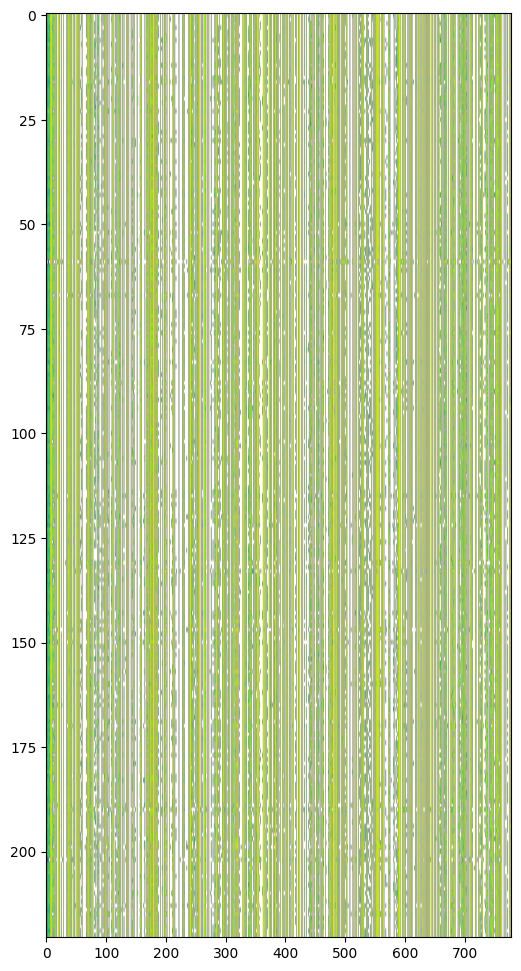

In [21]:
plt.figure(figsize=(6, 12))
plt.imshow(np.log(np.vstack([test_real_before,test_fake_before])), aspect='auto')
plt.savefig('embed_before.svg')

<ipython-input-22-a372b081f397>:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(np.vstack([test_real_after,test_fake_after])))


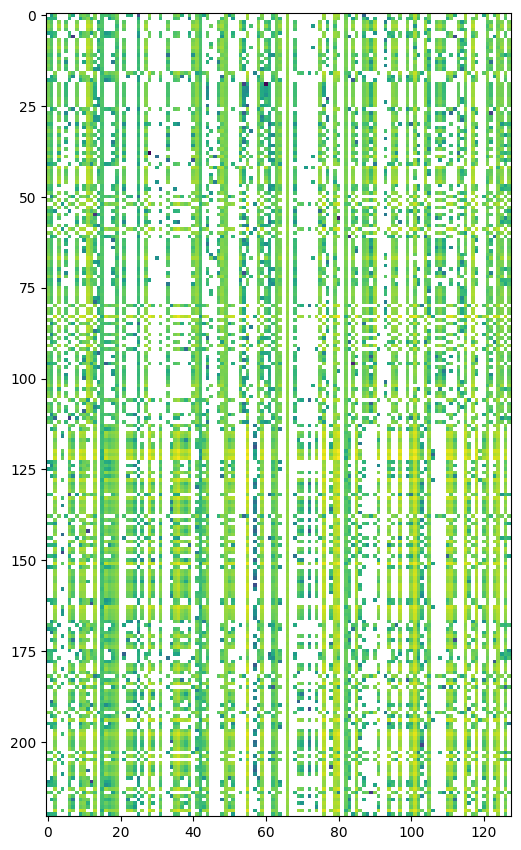

In [22]:
plt.figure(figsize=(6, 12))
plt.imshow(np.log(np.vstack([test_real_after,test_fake_after])))
plt.savefig('embed_after.svg')

# GNN-DP

## Load Data

For Differential Pooling, we will use the torch_geometric.nn.dense_diff_pool module, which requires adjacency matrix as input as opposed to edge_index. So, when loading data, we apply an additional toDense transformation.

In return, the loaded train/test/val data will have a feature adj (in lieu of edge_index).Given the max_node is set as 500, the adjacency matrix for each graph will be of shape (500, 500).


In [23]:
def load_data(split, feature = None):
  """
  Load train, validation, and test data from the UPFD dataset in PyG. Concact node
  features *profile* and *bert*, which are Twitter user's profile attributes and
  historical tweets encoded through BERT respectively. toDense transformation is applied
  to return adjacency matrix.

  -------------------------------------
  split: 'train', 'val', or 'test' for retrieving the respective portion of UPFD.
  feature: 'content' or None for which features to retrieve
  -------------------------------------
  Return: PyG dataset object.
  """
  max_nodes = 500 # for convert to dense adj matrix, instead of edge_index

  if feature ==  'content':
    return UPFD('/tmp/test', "politifact", feature, split, transform= T.ToDense(max_nodes), pre_transform= ToUndirected())
  else:
    data_profile =  UPFD('/tmp/test', "politifact", "profile", split, transform= T.ToDense(max_nodes), pre_transform= ToUndirected())
    data_bert =  UPFD('/tmp/test', "politifact", "bert", split,  transform=T.ToDense(max_nodes), pre_transform=ToUndirected())
    data_profile.data.x = torch.cat((data_profile.data.x, data_bert.data.x),dim =1)
    return data_profile

In [24]:
# Retrieve data
train_data = load_data('train')
val_data = load_data('val')
test_data = load_data('test')

# Prepare data loader for GNN
batch_size = 16
train_loader = DenseDataLoader(train_data, batch_size, shuffle=True)
val_loader = DenseDataLoader(val_data, batch_size, shuffle=False)
test_loader = DenseDataLoader(test_data, batch_size, shuffle=False)

# Note in the model, data are access through train_data[idx];
# Adjacency matrix can be access through train_data[idx].adj
stats = {'train': [train_data.data.x.shape,  train_data.data.y.shape, train_data.data.edge_index.shape],
         'val': [val_data.data.x.shape,  val_data.data.y.shape, val_data.data.edge_index.shape],
         'test': [test_data.data.x.shape,  test_data.data.y.shape, test_data.data.edge_index.shape]}
index_labels=['x','y','edge_idx']
stats = pd.DataFrame(stats, index = index_labels)
stats

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


,train,val,test
x,"(6072, 778)","(3778, 778)","(31204, 778)"
y,"(62,)","(31,)","(221,)"
edge_idx,"(2, 6010)","(2, 3747)","(2, 30983)"


In [25]:
# note the actual dimension of the adj matrix is now 500 x 500
train_data[0]

Data(x=[500, 778], y=[1], adj=[500, 500], mask=[500])

## GNN-DP Architecture
GNN-DP has two main parts.


In [26]:
from torch.nn.modules.batchnorm import BatchNorm1d

class GNN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, normalize = False, lin = False):
    """
    Initialize a customoized GNN with specific parameters.

    By default, this GCN has 2 convolutional layers and 1 linear layer if argument lin is set to be True.
    It also has 1 layer of batch normalization between the two conv-layers.

    The final output is the concatenated sequantial outputs of the DenseSageConv and Batchnorms layers.

    -------------------------------------
    self: GNN object
    input_dim: dimension of the input
    hidden_dim: dimension of the hidden layer(s)
    output_dim: dimension of the output (i.e. number of classes)
    normalize: True or False
    lin: True or False
    """
    super(GNN, self).__init__()

    self.conv1 = DenseSAGEConv(input_dim, hidden_dim, normalize)
    self.bn1= BatchNorm1d(hidden_dim)

    self.conv2 = DenseSAGEConv(hidden_dim, output_dim, normalize)
    self.bn2= BatchNorm1d(output_dim)

    if lin:
      self.lin = torch.nn.Linear(hidden_dim + output_dim, output_dim)
    else:
      self.lin = None

    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

  def forward(self, x, adj,mask = None):
    #make a copy of x
    batch_size, max_nodes, input_dim = x.shape
    x0 = x

    #sequentially feed through [GraphSageConv -> relu -> BatchNorm1d] x 2
    x1 = F.relu(self.conv1(x0, adj, mask)).view(-1, self.hidden_dim)
    x1 = self.bn1(x1).view(batch_size, -1, self.hidden_dim)

    x2 = F.relu(self.conv2(x1, adj, mask)).view(-1, self.output_dim)
    x2 = self.bn2(x2).view(batch_size, -1, self.output_dim)

    #concatenate the output x1, x2
    out = torch.cat([x1, x2], dim = -1)

    #lin is only needed for assignment GNN, not for embedding GNN
    if self.lin:
      out = F.relu(self.lin(out))

    return out

In [27]:
class GNNDP(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    """
    Initialize a Graph Neural Network with Differential Pooling (GNNDP) with specific parameters.


    The embedding matrix and the assignment matrix of eacg graph are computed by two separate customized GNN models respectively.
    In the 2 DIFFPOOL layer architecture, the number of clusters is set as 20% of the number of nodes before applying DIFFPOOL.
    As a result, with max_node=500, we reduce the nodes to 100 then 20.
    A final GNN layer is applied to compute the embedding matrix before mean aggregation for each graph.

    The final output is 2 class prediction softmax logits after applying relu activation and a affine layer.
    -------------------------------------
    self: GNNDP object
    input_dim: dimension of the input
    hidden_dim: dimension of the hidden layer(s)
    output_dim: dimension of the output (i.e. number of classes)
    """
    super(GNNDP,self).__init__()
    max_nodes = 500

    num_nodes = ceil(0.2 * max_nodes)
    #note below that gnn1_pool has lin=True for cluster assignment, but gnn1_embed has lin=False
    self.gnn1_pool = GNN(input_dim, hidden_dim, num_nodes, lin=True)
    self.gnn1_embed = GNN(input_dim, hidden_dim, hidden_dim, lin=False)

    num_nodes = ceil(0.2 * num_nodes)
    self.gnn2_pool = GNN(hidden_dim *2, hidden_dim, num_nodes, lin=True)
    self.gnn2_embed = GNN(hidden_dim *2, hidden_dim, hidden_dim, lin=False)

    self.gnn3_embed = GNN(2 * hidden_dim, hidden_dim, hidden_dim, lin=False)

    self.lin1 = torch.nn.Linear(2 * hidden_dim, hidden_dim)
    self.lin2 = torch.nn.Linear(hidden_dim, output_dim)

  def forward(self, x, adj, mask):
    #first diff pool: s for assignment, x for embedding; train both GNNs simultaneuously
    #note below that gnn1_pool has lin=True for cluster assignment, but gnn1_embed has lin=False
    s = self.gnn1_pool(x, adj, mask)
    x = self.gnn1_embed(x, adj, mask)
    x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask) #out, out_adj, link_loss, ent_loss; out is cluster embedding of size B x C x Feature_dimension


    #2nd diff pool, with reduced assignment size [num_nodes = ceil(0.25 * num_nodes)]
    s = self.gnn2_pool(x, adj)
    x = self.gnn2_embed(x, adj)
    x, adj, l2, e2 = dense_diff_pool(x, adj, s)

    #update embedding again, without calculating new assignemnt
    x = self.gnn3_embed(x, adj)

    #calculate new assignemnt with a linear layer
    x = x.mean(dim=1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)

    #return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2
    return F.softmax(x, dim=-1), l1 + l2, e1 + e2



What are the shape of the intermediate embeddings and cluster assignments?

1st pool:
* cluster assignmenet shape is torch.Size([16, 500, 100]),  embedding shape is torch.Size([16, 500, 64])
* post diff pool, embedding shape is torch.Size([16, 100, 64]), adj matrix shape is torch.Size([16, 100, 100])

2nd pool:
* cluster assignmenet shape is torch.Size([16, 100, 20]),  embedding shape is torch.Size([16, 100, 64])
* post diff pool, embedding shape is torch.Size([16, 20, 64]), adj matrix shape is torch.Size([16, 20, 20])

3rd gnn, embedding shape is torch.Size([14, 20, 64])

Final prediction shape is ([16,2])

## GNN-DP Model Training

In [28]:
def train():
  """
  Train the model using given data, optimizer, and loss_fn
  --------------------------------------
  model: the model we specified
  data: train data multiple batches of graphs, therefore needs to loop through each batch of graph
        and add loss of each graph results.
  """
  model.train()
  loss_all = 0
  pred = []
  label = []

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
    out, _, _ = model(data.x, data.adj, data.mask)
    #loss = F.nll_loss(out, data.y.view(-1))
    loss = F.cross_entropy(out, data.y.view(-1))
    loss_all += data.y.size(0) * loss.item()
    loss.backward()
    optimizer.step()
    pred_y = out.argmax(dim=-1, keepdim=True).tolist()
    pred.extend(pred_y)
    label.extend(data.y.tolist())

  acc = accuracy_score(label, pred)
  f1 = f1_score(label, pred)
  auc = roc_auc_score(label, pred)

  return acc , f1, auc , loss_all / len(train_loader.dataset)


## GNN-DP Model Performance

In [29]:
@torch.no_grad()
def evaluate(model, loader):
  """
  Evaluate performance based on the eval_metric.
  """

  # Put model in evaluation mode
  model.eval()

  pred = []
  label = []
  loss_test = 0

  for data in loader:
    data = data.to(device)
    out, _, _ = model(data.x, data.adj, data.mask)
    pred_y = out.argmax(dim=-1, keepdim=True).tolist()
    pred.extend(pred_y)
    label.extend(data.y.tolist())
    #loss = F.nll_loss(out, data.y.view(-1))
    loss = F.cross_entropy(out, data.y.view(-1))
    loss_test += data.y.size(0) * loss.item()

  acc = accuracy_score(label, pred)
  f1 = f1_score(label, pred)
  auc = roc_auc_score(label, pred)

  return acc, f1, auc, loss_test/len(loader.dataset)

## GNN-DP Run Model

In [30]:
seed = 777
torch.manual_seed(seed)

if torch.cuda.is_available():
	torch.cuda.manual_seed(seed)

num_classes = train_data.num_classes
num_features = train_data.num_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNDP(input_dim=num_features,hidden_dim =32, output_dim=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model = model.to(device)

In [33]:
import pandas as pd
import copy
from tqdm import tqdm
import torch.nn.functional as F

best_model = None
best_val_value = 0
epochs = 100

evaluator = eval
loss_fn = F.nll_loss

results = []  # List to collect results for each epoch

model.train()
for epoch in tqdm(range(epochs)):
    acc_train, f1_train, auc_train, loss_train = train()
    acc_val, f1_val, auc_val, loss_val = evaluate(model, val_loader)

    if acc_val > best_val_value:
        best_val_value = acc_val
        best_model = copy.deepcopy(model)

    results.append({
        'train_acc': acc_train, 'train_f1': f1_train, 'train_auc': auc_train, 'train_loss': loss_train,
        'val_acc': acc_val, 'val_f1': f1_val, 'val_auc': auc_val, 'val_loss': loss_val
    })

    print(f'loss_train: {loss_train:.4f}, acc_train: {acc_train:.4f}, '
          f'loss_val: {loss_val:.4f}, acc_val: {acc_val:.4f}.')

# Convert results to DataFrame
resultdf = pd.DataFrame(results)


  1%|          | 1/100 [00:00<00:31,  3.18it/s]

loss_train: 0.6911, acc_train: 0.5000, loss_val: 0.7033, acc_val: 0.4194.


  2%|▏         | 2/100 [00:00<00:31,  3.16it/s]

loss_train: 0.6836, acc_train: 0.5000, loss_val: 0.7028, acc_val: 0.4194.


  3%|▎         | 3/100 [00:00<00:31,  3.13it/s]

loss_train: 0.6798, acc_train: 0.5806, loss_val: 0.7104, acc_val: 0.4194.


  4%|▍         | 4/100 [00:01<00:32,  2.99it/s]

loss_train: 0.6549, acc_train: 0.6452, loss_val: 0.7144, acc_val: 0.4194.


  5%|▌         | 5/100 [00:01<00:31,  3.02it/s]

loss_train: 0.6439, acc_train: 0.6935, loss_val: 0.7201, acc_val: 0.3871.


  6%|▌         | 6/100 [00:01<00:31,  3.02it/s]

loss_train: 0.6371, acc_train: 0.7097, loss_val: 0.7232, acc_val: 0.3871.


  7%|▋         | 7/100 [00:02<00:30,  3.00it/s]

loss_train: 0.6187, acc_train: 0.7419, loss_val: 0.7323, acc_val: 0.4194.


  8%|▊         | 8/100 [00:02<00:30,  3.00it/s]

loss_train: 0.6056, acc_train: 0.7903, loss_val: 0.7125, acc_val: 0.4516.


  9%|▉         | 9/100 [00:02<00:30,  3.02it/s]

loss_train: 0.5976, acc_train: 0.7903, loss_val: 0.7147, acc_val: 0.4516.


 10%|█         | 10/100 [00:03<00:30,  2.99it/s]

loss_train: 0.5880, acc_train: 0.7742, loss_val: 0.6718, acc_val: 0.6129.


 11%|█         | 11/100 [00:03<00:29,  2.99it/s]

loss_train: 0.5536, acc_train: 0.9032, loss_val: 0.6494, acc_val: 0.6452.


 12%|█▏        | 12/100 [00:03<00:29,  3.03it/s]

loss_train: 0.5510, acc_train: 0.9032, loss_val: 0.6288, acc_val: 0.6452.


 13%|█▎        | 13/100 [00:04<00:28,  3.03it/s]

loss_train: 0.5221, acc_train: 0.9032, loss_val: 0.6486, acc_val: 0.6452.


 14%|█▍        | 14/100 [00:04<00:28,  3.05it/s]

loss_train: 0.5142, acc_train: 0.8548, loss_val: 0.6676, acc_val: 0.5484.


 15%|█▌        | 15/100 [00:04<00:27,  3.08it/s]

loss_train: 0.4961, acc_train: 0.8710, loss_val: 0.6914, acc_val: 0.5161.


 16%|█▌        | 16/100 [00:05<00:27,  3.04it/s]

loss_train: 0.4686, acc_train: 0.9032, loss_val: 0.6416, acc_val: 0.6774.


 17%|█▋        | 17/100 [00:05<00:26,  3.08it/s]

loss_train: 0.4742, acc_train: 0.9032, loss_val: 0.5887, acc_val: 0.7097.


 18%|█▊        | 18/100 [00:05<00:26,  3.07it/s]

loss_train: 0.4375, acc_train: 0.9516, loss_val: 0.5716, acc_val: 0.7419.


 19%|█▉        | 19/100 [00:06<00:27,  2.99it/s]

loss_train: 0.4337, acc_train: 0.9355, loss_val: 0.5717, acc_val: 0.7419.


 20%|██        | 20/100 [00:06<00:26,  3.05it/s]

loss_train: 0.4341, acc_train: 0.9355, loss_val: 0.5850, acc_val: 0.6774.


 21%|██        | 21/100 [00:06<00:26,  2.96it/s]

loss_train: 0.3988, acc_train: 1.0000, loss_val: 0.5454, acc_val: 0.7742.


 22%|██▏       | 22/100 [00:07<00:27,  2.86it/s]

loss_train: 0.4115, acc_train: 0.9677, loss_val: 0.8178, acc_val: 0.4516.


 23%|██▎       | 23/100 [00:07<00:27,  2.79it/s]

loss_train: 0.3957, acc_train: 0.9516, loss_val: 0.6198, acc_val: 0.7097.


 24%|██▍       | 24/100 [00:08<00:27,  2.79it/s]

loss_train: 0.3798, acc_train: 0.9677, loss_val: 0.5156, acc_val: 0.8065.


 25%|██▌       | 25/100 [00:08<00:26,  2.81it/s]

loss_train: 0.3746, acc_train: 0.9839, loss_val: 0.4941, acc_val: 0.8065.


 26%|██▌       | 26/100 [00:08<00:26,  2.77it/s]

loss_train: 0.3645, acc_train: 0.9839, loss_val: 0.5016, acc_val: 0.8387.


 27%|██▋       | 27/100 [00:09<00:25,  2.85it/s]

loss_train: 0.3553, acc_train: 0.9839, loss_val: 0.5602, acc_val: 0.7097.


 28%|██▊       | 28/100 [00:09<00:24,  2.90it/s]

loss_train: 0.3432, acc_train: 1.0000, loss_val: 0.6397, acc_val: 0.6129.


 29%|██▉       | 29/100 [00:09<00:24,  2.86it/s]

loss_train: 0.3341, acc_train: 1.0000, loss_val: 0.6214, acc_val: 0.6452.


 30%|███       | 30/100 [00:10<00:25,  2.79it/s]

loss_train: 0.3558, acc_train: 0.9839, loss_val: 0.5835, acc_val: 0.7097.


 31%|███       | 31/100 [00:10<00:23,  2.90it/s]

loss_train: 0.3403, acc_train: 0.9839, loss_val: 0.5667, acc_val: 0.7419.


 32%|███▏      | 32/100 [00:10<00:22,  3.01it/s]

loss_train: 0.3431, acc_train: 0.9839, loss_val: 0.6241, acc_val: 0.6774.


 33%|███▎      | 33/100 [00:11<00:21,  3.12it/s]

loss_train: 0.3636, acc_train: 0.9516, loss_val: 0.7062, acc_val: 0.5484.


 34%|███▍      | 34/100 [00:11<00:20,  3.21it/s]

loss_train: 0.3438, acc_train: 1.0000, loss_val: 0.6093, acc_val: 0.6774.


 35%|███▌      | 35/100 [00:11<00:20,  3.16it/s]

loss_train: 0.3274, acc_train: 1.0000, loss_val: 0.5844, acc_val: 0.6774.


 36%|███▌      | 36/100 [00:12<00:19,  3.22it/s]

loss_train: 0.3329, acc_train: 0.9839, loss_val: 0.6005, acc_val: 0.7097.


 37%|███▋      | 37/100 [00:12<00:19,  3.29it/s]

loss_train: 0.3256, acc_train: 1.0000, loss_val: 0.5254, acc_val: 0.7419.


 38%|███▊      | 38/100 [00:12<00:18,  3.33it/s]

loss_train: 0.3368, acc_train: 1.0000, loss_val: 0.8763, acc_val: 0.4194.


 39%|███▉      | 39/100 [00:12<00:18,  3.34it/s]

loss_train: 0.3465, acc_train: 0.9839, loss_val: 0.8887, acc_val: 0.4194.


 40%|████      | 40/100 [00:13<00:17,  3.34it/s]

loss_train: 0.3748, acc_train: 0.9677, loss_val: 0.8455, acc_val: 0.4194.


 41%|████      | 41/100 [00:13<00:17,  3.37it/s]

loss_train: 0.3295, acc_train: 0.9839, loss_val: 0.8408, acc_val: 0.4194.


 42%|████▏     | 42/100 [00:13<00:17,  3.37it/s]

loss_train: 0.3419, acc_train: 0.9677, loss_val: 0.8921, acc_val: 0.4194.


 43%|████▎     | 43/100 [00:14<00:16,  3.38it/s]

loss_train: 0.3721, acc_train: 0.9355, loss_val: 0.8209, acc_val: 0.4516.


 44%|████▍     | 44/100 [00:14<00:16,  3.39it/s]

loss_train: 0.3669, acc_train: 0.9516, loss_val: 0.5556, acc_val: 0.7419.


 45%|████▌     | 45/100 [00:14<00:16,  3.41it/s]

loss_train: 0.4003, acc_train: 0.9194, loss_val: 0.5392, acc_val: 0.8065.


 46%|████▌     | 46/100 [00:14<00:15,  3.39it/s]

loss_train: 0.3624, acc_train: 0.9355, loss_val: 0.5501, acc_val: 0.7097.


 47%|████▋     | 47/100 [00:15<00:15,  3.40it/s]

loss_train: 0.3289, acc_train: 0.9839, loss_val: 0.6012, acc_val: 0.6774.


 48%|████▊     | 48/100 [00:15<00:15,  3.41it/s]

loss_train: 0.3498, acc_train: 0.9839, loss_val: 0.7782, acc_val: 0.5161.


 49%|████▉     | 49/100 [00:15<00:14,  3.42it/s]

loss_train: 0.3635, acc_train: 0.9516, loss_val: 0.5279, acc_val: 0.7742.


 50%|█████     | 50/100 [00:16<00:14,  3.42it/s]

loss_train: 0.3208, acc_train: 1.0000, loss_val: 0.6016, acc_val: 0.7097.


 51%|█████     | 51/100 [00:16<00:14,  3.45it/s]

loss_train: 0.3616, acc_train: 0.9516, loss_val: 0.6237, acc_val: 0.6774.


 52%|█████▏    | 52/100 [00:16<00:13,  3.45it/s]

loss_train: 0.3736, acc_train: 0.9194, loss_val: 0.5274, acc_val: 0.7742.


 53%|█████▎    | 53/100 [00:16<00:13,  3.41it/s]

loss_train: 0.3317, acc_train: 0.9839, loss_val: 0.7272, acc_val: 0.5484.


 54%|█████▍    | 54/100 [00:17<00:13,  3.30it/s]

loss_train: 0.3502, acc_train: 0.9516, loss_val: 0.8620, acc_val: 0.4194.


 55%|█████▌    | 55/100 [00:17<00:13,  3.31it/s]

loss_train: 0.3275, acc_train: 1.0000, loss_val: 0.7821, acc_val: 0.5161.


 56%|█████▌    | 56/100 [00:17<00:13,  3.32it/s]

loss_train: 0.3244, acc_train: 1.0000, loss_val: 0.6956, acc_val: 0.5806.


 57%|█████▋    | 57/100 [00:18<00:12,  3.32it/s]

loss_train: 0.3350, acc_train: 0.9839, loss_val: 0.6662, acc_val: 0.6129.


 58%|█████▊    | 58/100 [00:18<00:12,  3.28it/s]

loss_train: 0.3679, acc_train: 0.9516, loss_val: 0.5500, acc_val: 0.7419.


 59%|█████▉    | 59/100 [00:18<00:12,  3.31it/s]

loss_train: 0.3204, acc_train: 1.0000, loss_val: 0.5222, acc_val: 0.7742.


 60%|██████    | 60/100 [00:19<00:12,  3.31it/s]

loss_train: 0.3206, acc_train: 1.0000, loss_val: 0.5758, acc_val: 0.6774.


 61%|██████    | 61/100 [00:19<00:11,  3.35it/s]

loss_train: 0.3939, acc_train: 0.9355, loss_val: 0.7964, acc_val: 0.5161.


 62%|██████▏   | 62/100 [00:19<00:11,  3.37it/s]

loss_train: 0.3490, acc_train: 0.9677, loss_val: 0.8349, acc_val: 0.4839.


 63%|██████▎   | 63/100 [00:20<00:11,  3.25it/s]

loss_train: 0.3611, acc_train: 0.9516, loss_val: 0.8548, acc_val: 0.4516.


 64%|██████▍   | 64/100 [00:20<00:11,  3.08it/s]

loss_train: 0.3714, acc_train: 0.9355, loss_val: 0.8569, acc_val: 0.4516.


 65%|██████▌   | 65/100 [00:20<00:11,  3.10it/s]

loss_train: 0.3756, acc_train: 0.9355, loss_val: 0.6909, acc_val: 0.5806.


 66%|██████▌   | 66/100 [00:21<00:11,  3.07it/s]

loss_train: 0.3729, acc_train: 0.9516, loss_val: 0.6043, acc_val: 0.7097.


 67%|██████▋   | 67/100 [00:21<00:10,  3.03it/s]

loss_train: 0.3397, acc_train: 0.9839, loss_val: 0.6204, acc_val: 0.7097.


 68%|██████▊   | 68/100 [00:21<00:10,  3.03it/s]

loss_train: 0.3264, acc_train: 1.0000, loss_val: 0.5004, acc_val: 0.8065.


 69%|██████▉   | 69/100 [00:22<00:10,  3.00it/s]

loss_train: 0.3187, acc_train: 1.0000, loss_val: 0.5271, acc_val: 0.7742.


 70%|███████   | 70/100 [00:22<00:10,  2.92it/s]

loss_train: 0.3254, acc_train: 0.9839, loss_val: 0.5633, acc_val: 0.7419.


 71%|███████   | 71/100 [00:22<00:09,  2.93it/s]

loss_train: 0.3372, acc_train: 0.9839, loss_val: 0.5703, acc_val: 0.7419.


 72%|███████▏  | 72/100 [00:23<00:09,  2.93it/s]

loss_train: 0.3408, acc_train: 0.9839, loss_val: 0.6395, acc_val: 0.6129.


 73%|███████▎  | 73/100 [00:23<00:09,  2.88it/s]

loss_train: 0.3482, acc_train: 0.9677, loss_val: 0.6533, acc_val: 0.6452.


 74%|███████▍  | 74/100 [00:23<00:08,  3.02it/s]

loss_train: 0.3859, acc_train: 0.9355, loss_val: 0.6339, acc_val: 0.6774.


 75%|███████▌  | 75/100 [00:24<00:08,  3.11it/s]

loss_train: 0.3649, acc_train: 0.9355, loss_val: 0.5894, acc_val: 0.7097.


 76%|███████▌  | 76/100 [00:24<00:07,  3.18it/s]

loss_train: 0.3512, acc_train: 0.9677, loss_val: 0.6350, acc_val: 0.6774.


 77%|███████▋  | 77/100 [00:24<00:07,  3.25it/s]

loss_train: 0.3777, acc_train: 0.9355, loss_val: 0.5822, acc_val: 0.7419.


 78%|███████▊  | 78/100 [00:24<00:06,  3.21it/s]

loss_train: 0.3171, acc_train: 1.0000, loss_val: 0.4905, acc_val: 0.8065.


 79%|███████▉  | 79/100 [00:25<00:06,  3.25it/s]

loss_train: 0.3810, acc_train: 0.9355, loss_val: 0.8936, acc_val: 0.4194.


 80%|████████  | 80/100 [00:25<00:06,  3.30it/s]

loss_train: 0.3570, acc_train: 0.9677, loss_val: 0.7844, acc_val: 0.5161.


 81%|████████  | 81/100 [00:25<00:05,  3.33it/s]

loss_train: 0.3399, acc_train: 0.9839, loss_val: 0.6607, acc_val: 0.6452.


 82%|████████▏ | 82/100 [00:26<00:05,  3.36it/s]

loss_train: 0.3407, acc_train: 0.9677, loss_val: 0.6863, acc_val: 0.6129.


 83%|████████▎ | 83/100 [00:26<00:05,  3.38it/s]

loss_train: 0.3194, acc_train: 1.0000, loss_val: 0.6870, acc_val: 0.6129.


 84%|████████▍ | 84/100 [00:26<00:04,  3.40it/s]

loss_train: 0.3290, acc_train: 0.9839, loss_val: 0.6628, acc_val: 0.6452.


 85%|████████▌ | 85/100 [00:27<00:04,  3.31it/s]

loss_train: 0.3331, acc_train: 0.9839, loss_val: 0.6088, acc_val: 0.7097.


 86%|████████▌ | 86/100 [00:27<00:04,  3.34it/s]

loss_train: 0.3503, acc_train: 0.9516, loss_val: 0.6065, acc_val: 0.6774.


 87%|████████▋ | 87/100 [00:27<00:03,  3.37it/s]

loss_train: 0.3472, acc_train: 0.9677, loss_val: 0.5805, acc_val: 0.7097.


 88%|████████▊ | 88/100 [00:27<00:03,  3.38it/s]

loss_train: 0.3186, acc_train: 1.0000, loss_val: 0.5429, acc_val: 0.7419.


 89%|████████▉ | 89/100 [00:28<00:03,  3.39it/s]

loss_train: 0.3219, acc_train: 1.0000, loss_val: 0.6748, acc_val: 0.6452.


 90%|█████████ | 90/100 [00:28<00:02,  3.39it/s]

loss_train: 0.3431, acc_train: 0.9677, loss_val: 0.6822, acc_val: 0.6129.


 91%|█████████ | 91/100 [00:28<00:02,  3.41it/s]

loss_train: 0.3272, acc_train: 0.9839, loss_val: 0.5796, acc_val: 0.7419.


 92%|█████████▏| 92/100 [00:29<00:02,  3.41it/s]

loss_train: 0.3347, acc_train: 0.9839, loss_val: 0.5708, acc_val: 0.7419.


 93%|█████████▎| 93/100 [00:29<00:02,  3.43it/s]

loss_train: 0.3336, acc_train: 0.9839, loss_val: 0.5531, acc_val: 0.7419.


 94%|█████████▍| 94/100 [00:29<00:01,  3.42it/s]

loss_train: 0.3496, acc_train: 0.9516, loss_val: 0.7064, acc_val: 0.5806.


 95%|█████████▌| 95/100 [00:29<00:01,  3.42it/s]

loss_train: 0.3215, acc_train: 1.0000, loss_val: 0.8360, acc_val: 0.4839.


 96%|█████████▌| 96/100 [00:30<00:01,  3.34it/s]

loss_train: 0.3339, acc_train: 0.9839, loss_val: 0.8296, acc_val: 0.4839.


 97%|█████████▋| 97/100 [00:30<00:00,  3.27it/s]

loss_train: 0.3510, acc_train: 0.9677, loss_val: 0.7681, acc_val: 0.5161.


 98%|█████████▊| 98/100 [00:30<00:00,  3.30it/s]

loss_train: 0.3234, acc_train: 1.0000, loss_val: 0.6175, acc_val: 0.6774.


 99%|█████████▉| 99/100 [00:31<00:00,  3.27it/s]

loss_train: 0.3582, acc_train: 0.9516, loss_val: 0.7121, acc_val: 0.5806.


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]

loss_train: 0.3761, acc_train: 0.9355, loss_val: 0.6927, acc_val: 0.6129.


In [35]:
#[acc, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = evaluate(test_loader)
acc, f1, auc, _ = evaluate(best_model, test_loader)
print(f'Test set results: acc: {acc:.4f}, f1: {f1:.4f}, auc: {auc:.4f}')


Test set results: acc: 0.8054, f1: 0.8037, auc: 0.8060
